In [ ]:
"""
DATASET:
1. https://data.mendeley.com/datasets/rscbjbr9sj/2
"""
"""
CITE:
1.17632/rscbjbr9sj.2#file-f12eaf6d-6023-432f-acc9-80c9d7393433
"""

"""
REFERENCES:
1. https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c
2. https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/


NOTE:
  We need high recall because in medical cases even if there is a low suspicion that the paitent 
  is infected then he can be tested using a proper classical method. 
  This model based classification should only be used to predict liklihood at that instant itself. 
  It could help speed up the whole process to some extent and provide the patient with a rough idea about his health.
  Conclusion: We need minimal False Negatives.
"""

!wget -nc -O ChestXRay.zip https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497
!unzip -q ChestXRay.zip
!find . -name '.DS_Store' -type f -delete
!find . -name '__MACOSX' -type f -delete
!find . -name '__MACOSX' -type d -exec rm -rf {} \;
!find . -name '.config' -type d -exec rm -rf {} \;
!du


--2021-01-06 09:42:26--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.24.56
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.24.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1235512464 (1.2G) [application/zip]
Saving to: ‘ChestXRay.zip’

ChestXRay.zip       100%[===================>]   1.15G  21.8MB/s    in 56s     

2021-01-06 09:43:23 (21.1 MB/s) - ‘ChestXRay.zip’ saved [1235512464/1235512464]

find: ‘./__MACOSX’: No such file or directory
find: ‘./.config’: No such file or directory
806024	./chest_xray/train/NORMAL
335024	./chest_xray/train/PNEUMONIA
1141052	./chest_xray/train
49100	./chest_xray/test/NORMAL
29356	./chest_xray/test/PNEUMONIA
78460	./chest_xray/test
1219516	./ch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
import os
import shutil
np.random.seed(5)
tf.random.set_seed(5)

In [ ]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    resized = cv2.resize(image, dim, interpolation = inter)
    return resized

def get_photo_gallery(images_arr, n_row = 2, n_col = 5):
    images_arr = images_arr.copy()
    counter = 0
    himages = []
    vimages = []
    if len(images_arr) < (n_row * n_col):
      for i in range((n_row * n_col) - len(images_arr)):
        images_arr.append(np.zeros(images_arr[0].shape[:2]))
    for i in range(n_row):
        for j in range(n_col):
            himages.append(images_arr[counter])
            counter+=1
        himage=np.hstack((himages))
        vimages.append(himage)
        himages = []
    image_matrix = np.vstack((vimages))
    return image_matrix

In [ ]:
# 82.6% Training set :: 5.4% Validation set :: 12% Test set
datagen_train_validation = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2, 
                                   rotation_range = 10, 
                                   width_shift_range = 0.1,  
                                   height_shift_range = 0.1, 
                                   horizontal_flip = True,
                                   validation_split = 0.06)  
                                  

training_set = datagen_train_validation.flow_from_directory('chest_xray/train',
                                  target_size = (300, 300),
                                  batch_size = 32,
                                  shuffle = True,
                                  seed = 5,
                                  color_mode = 'grayscale',
                                  class_mode = 'binary',
                                  subset='training')

validation_set = datagen_train_validation.flow_from_directory('chest_xray/train',
                                  target_size = (300, 300),
                                  batch_size = 32,
                                  shuffle = True,
                                  seed = 5,
                                  color_mode = 'grayscale',
                                  class_mode = 'binary',
                                  subset = 'validation')

datagen_test = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2, 
                                   rotation_range = 10, 
                                   width_shift_range = 0.1,  
                                   height_shift_range = 0.1, 
                                   horizontal_flip = True)

test_set = datagen_test.flow_from_directory('chest_xray/test',
                                  target_size = (300, 300),
                                  batch_size = 32,
                                  shuffle = True,
                                  seed = 5,
                                  color_mode = 'grayscale',
                                  class_mode = 'binary')

Found 4920 images belonging to 2 classes.
Found 312 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


NORMAL Cases:


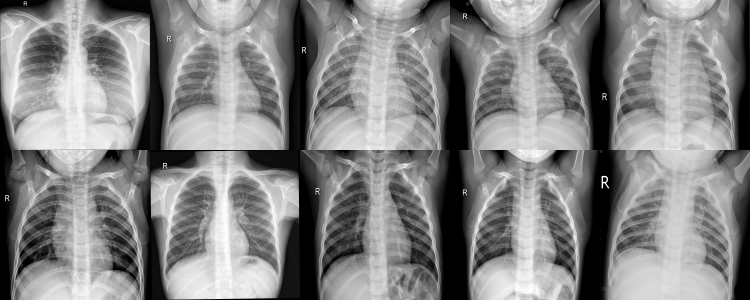


PNEUMONIA Cases:


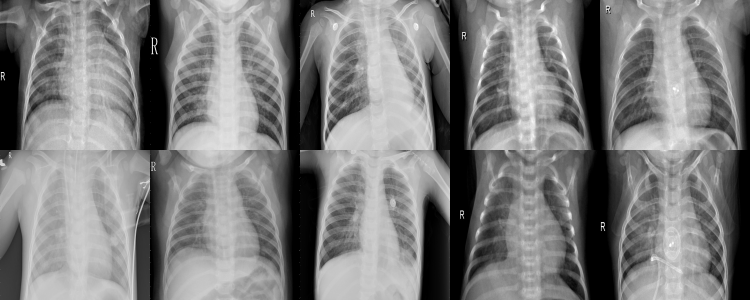

In [ ]:
NORMAL_arr = []
path_of_class = '/content/chest_xray/train/NORMAL/'
file_list = os.listdir(path_of_class)
disp_lim = 10
lim_count = 0
for f in file_list:
  img = cv2.imread(path_of_class + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (150,150), interpolation = cv2.INTER_AREA)
  NORMAL_arr.append(img)
  lim_count += 1
  if lim_count == disp_lim : break

print("NORMAL Cases:")
cv2_imshow(get_photo_gallery(NORMAL_arr))
print()
del img
del path_of_class

PNEUMONIA_arr = []
path_of_class = '/content/chest_xray/train/PNEUMONIA/'
file_list = os.listdir(path_of_class)
disp_lim = 10
lim_count = 0
for f in file_list:
  img = cv2.imread(path_of_class + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (150,150), interpolation = cv2.INTER_AREA)
  PNEUMONIA_arr.append(img)
  lim_count += 1
  if lim_count == disp_lim : break

print("PNEUMONIA Cases:")
cv2_imshow(get_photo_gallery(PNEUMONIA_arr))

In [ ]:
model = tf.keras.models.Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(300, 300, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 'Precision', 'Recall'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 34, 34, 128)       0

In [ ]:
%mkdir Checkpoints

In [ ]:
#maximize RECALL
#take accuracy > 80%    Recall > 97%
#Recall and Acc are inv. proportional, since if we decrease FN, TN will increase
filepath = "Checkpoints/saved-model-{epoch:02d}-acc={accuracy:.2f}-recall={recall:.2f}-v_acc={val_accuracy:.2f}-v_recall={val_recall:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=False)

history = model.fit(x = training_set, 
                    validation_data = validation_set, 
                    steps_per_epoch=32, 
                    epochs = 6, 
                    shuffle=False, 
                    callbacks=[checkpoint])

#steps_per_epoch = how many times update weights per epoch

Epoch 1/6
32/32 [==============================] - ETA: 0s - loss: 0.2915 - accuracy: 0.8799 - precision: 0.9082 - recall: 0.9310
Epoch 00001: saving model to Checkpoints/saved-model-01-acc=0.88-recall=0.93-v_acc=0.89-v_recall=0.95.h5
32/32 [==============================] - 282s 9s/step - loss: 0.2915 - accuracy: 0.8799 - precision: 0.9082 - recall: 0.9310 - val_loss: 0.2460 - val_accuracy: 0.8910 - val_precision: 0.9057 - val_recall: 0.9526
Epoch 2/6
32/32 [==============================] - ETA: 0s - loss: 0.2859 - accuracy: 0.8867 - precision: 0.9211 - recall: 0.9259
Epoch 00002: saving model to Checkpoints/saved-model-02-acc=0.89-recall=0.93-v_acc=0.91-v_recall=0.95.h5
32/32 [==============================] - 280s 9s/step - loss: 0.2859 - accuracy: 0.8867 - precision: 0.9211 - recall: 0.9259 - val_loss: 0.2462 - val_accuracy: 0.9071 - val_precision: 0.9283 - val_recall: 0.9483
Epoch 3/6
32/32 [==============================] - ETA: 0s - loss: 0.2355 - accuracy: 0.9062 - precision: 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp -a /content/Checkpoints/. /content/gdrive/MyDrive/Models/

In [ ]:
import os
import h5py
chk_pt_lst = os.listdir('Checkpoints')

In [ ]:
#Also consider Augmented images generated using ImageDataGenerator to evaluate model
for cf in chk_pt_lst:
  model.load_weights('Checkpoints/' + cf)
  print(model.evaluate(test_set))

20/20 [==============================] - 43s 2s/step - loss: 0.4543 - accuracy: 0.8109 - precision: 0.7810 - recall: 0.9692
[0.4542526304721832, 0.8108974099159241, 0.7809917330741882, 0.9692307710647583]
20/20 [==============================] - 43s 2s/step - loss: 0.4959 - accuracy: 0.8173 - precision: 0.7924 - recall: 0.9590
[0.4958786964416504, 0.817307710647583, 0.7923728823661804, 0.9589743614196777]
20/20 [==============================] - 42s 2s/step - loss: 0.4537 - accuracy: 0.8013 - precision: 0.7842 - recall: 0.9410
[0.45373567938804626, 0.8012820482254028, 0.7841880321502686, 0.9410256147384644]
20/20 [==============================] - 42s 2s/step - loss: 0.4396 - accuracy: 0.8429 - precision: 0.8288 - recall: 0.9436
[0.43961164355278015, 0.8429487347602844, 0.8288288116455078, 0.9435897469520569]
20/20 [==============================] - 42s 2s/step - loss: 0.6926 - accuracy: 0.6971 - precision: 0.6748 - recall: 0.9949
[0.6926369667053223, 0.6971153616905212, 0.674782633781

In [ ]:
  print(model.evaluate(test_set))

20/20 [==============================] - 43s 2s/step - loss: 0.4686 - accuracy: 0.8333 - precision: 0.8310 - recall: 0.9205
[0.46858450770378113, 0.8333333134651184, 0.8310185074806213, 0.9205127954483032]


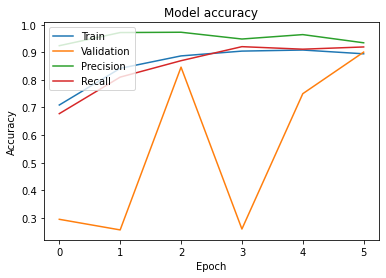

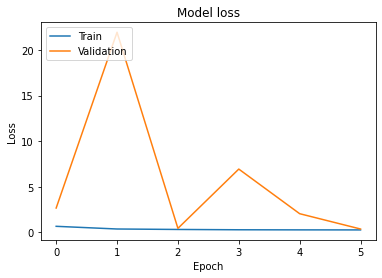

In [ ]:
# Plot training & validation accuracy, precision, recall values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['precision'])
plt.plot(history.history['recall'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Precision', 'Recall'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
history.model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 69, 69, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 34, 34, 128)      

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install ann_visualizer
!pip install graphviz

In [ ]:
! ls gdrive/MyDrive/Models/

'saved-model-01-acc=0.88-recall=0.93-v_acc=0.89-v_recall=0.95.h5'
'saved-model-02-acc=0.89-recall=0.93-v_acc=0.91-v_recall=0.95.h5'
'saved-model-03-acc=0.91-recall=0.95-v_acc=0.90-v_recall=0.97.h5'
'saved-model-04-acc=0.91-recall=0.95-v_acc=0.90-v_recall=0.94.h5'
'saved-model-05-acc=0.91-recall=0.93-v_acc=0.92-v_recall=0.91.h5'
'saved-model-06-acc=0.91-recall=0.94-v_acc=0.87-v_recall=0.96.h5'


In [ ]:
model = tf.keras.models.load_model('gdrive/MyDrive/Models/saved-model-03-acc=0.91-recall=0.95-v_acc=0.90-v_recall=0.97.h5')

In [ ]:
from ann_visualizer.visualize import ann_viz;
ann_viz(model, title="Pneumonia Detection - Neural Network")

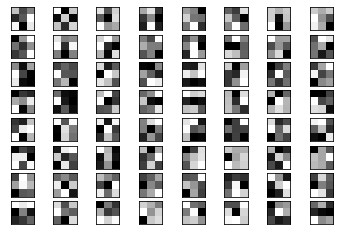

In [ ]:
from matplotlib import pyplot
filters, biases = model.layers[2].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = 8, 1
for i in range(n_filters):
  f = filters[:, :, :, i]
  for j in range(8):
    ax = pyplot.subplot(n_filters, 8, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    pyplot.imshow(f[:, :, j], cmap='gray')
    ix += 1
#pyplot.subplots_adjust(wspace=0, hspace=0)
pyplot.savefig('few_Conv_layer2_filters.pdf')